# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# keep matplotlib interactive
# NOTE: one must reload matplotlib to change of rendering style
%matplotlib notebook
# %matplotlib inline
# use ggplot style
plt.style.use('ggplot')

# Data Description
Description of transactions

                                                

|                                       transactions.csv                                        |
|-----------------------------------------------------------------------------------------------|
| msno                   | user id  (letters, digits and special characters)                    |
| payment_method_id      | payment method   (masked)                                            |
| payment_plan_days      | length of membership plan in days                                    |
| plan_list_price        | in New Taiwan Dollar (NTD)                                           |
| actual_amount_paid     | in New Taiwan Dollar (NTD)                                           |
| is_auto_renew          | true when customer opted in renewing its subscription automatically  |
| transaction_date       | format %Y%m%d                                                        |
| membership_expire_date | format %Y%m%d                                                        |
| is_cancel              | whether or not the user canceled the membership in this transaction. |



### Transactions

In [2]:
transaction_dir = os.path.join(os.pardir, 'data', 'raw', 'transactions.csv')
df_transac = pd.read_csv(transaction_dir, parse_dates=['transaction_date', 'membership_expire_date'])

In [3]:
df_transac.count()

msno                      21547746
payment_method_id         21547746
payment_plan_days         21547746
plan_list_price           21547746
actual_amount_paid        21547746
is_auto_renew             21547746
transaction_date          21547746
membership_expire_date    21547746
is_cancel                 21547746
dtype: int64

In [4]:
# treat payment_method_id as a category
df_transac.payment_method_id = df_transac.payment_method_id.astype('category')
# same for user
df_transac.msno = df_transac.msno.astype('category')
# convert relevant columns to boolean
df_transac.is_auto_renew = df_transac.is_auto_renew.astype(bool)
df_transac.is_cancel = df_transac.is_cancel.astype(bool)

In [5]:
df_transac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21547746 entries, 0 to 21547745
Data columns (total 9 columns):
msno                      category
payment_method_id         category
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             bool
transaction_date          datetime64[ns]
membership_expire_date    datetime64[ns]
is_cancel                 bool
dtypes: bool(2), category(2), datetime64[ns](2), int64(3)
memory usage: 1.0 GB


In [6]:
def plot_bar(df, bar_list, is_Norm=True):
    """
        Make a bar plot using dataframe df and associated columns in bar_list
        is_Norm will normalize distribution by counts
        df: pandas DataFrame
        bar_list: list of column names
    """
    # keep 2 columns and compute number of rows needed in subpots
    subrows = int(np.ceil(len(bar_list) / 2))
    discard_last_ax = bool(len(bar_list) % 2)
    
    # special case when there is only one column specified
    # then keep one figure and make it bigger
    if subrows == 1 and discard_last_ax:
        _ , ax = plt.subplots(figsize=(9,5))
        ax = [ax]
    else:
        _ , ax = plt.subplots(subrows, 2)
        ax = ax.flatten()
    for k, colname in enumerate(bar_list):
        
        # select column and make bar plot
        s_colname = df[colname]
        distrib = s_colname.value_counts(normalize = is_Norm).sort_index()*100
        distrib.plot(kind='bar', ax=ax[k], color='b')
        
        # add percent character to y tick label if plot normalized
        if is_Norm:
            # add percent on y axis labels, uses numerical value of each tick (just in case scale has changed)
#             ax[k].set_yticklabels([ '{:.0f}%'.format(l)  for l in ax[k].get_yticks()])
            pass
        else:
            ax[k].set_ylabel('Count')
                
        # reformat existing x ticklabels to integer (may not be required)
        # When numeric columns have Nans then it will show float number
        # ax[k].set_xticklabels([ '{:.0f}'.format(float(l.get_text()))  for l in ax[k].get_xticklabels()])
        
        # add title
        ax[k].set_title(distrib.name + ' Distribution')
        
        # reset x axis label to 45 rotation
        ax[k].tick_params(axis = 'x', rotation = 45)
        
        # add x axis label
        ax[k].set_xlabel(distrib.name)
        
    # decide to keep last axes
    if discard_last_ax and subrows > 1: ax[-1].set_visible(False)
    plt.tight_layout()

### Payment ID method
Payment ID 41 represents more than 50% of transactions

<IPython.core.display.Javascript object>


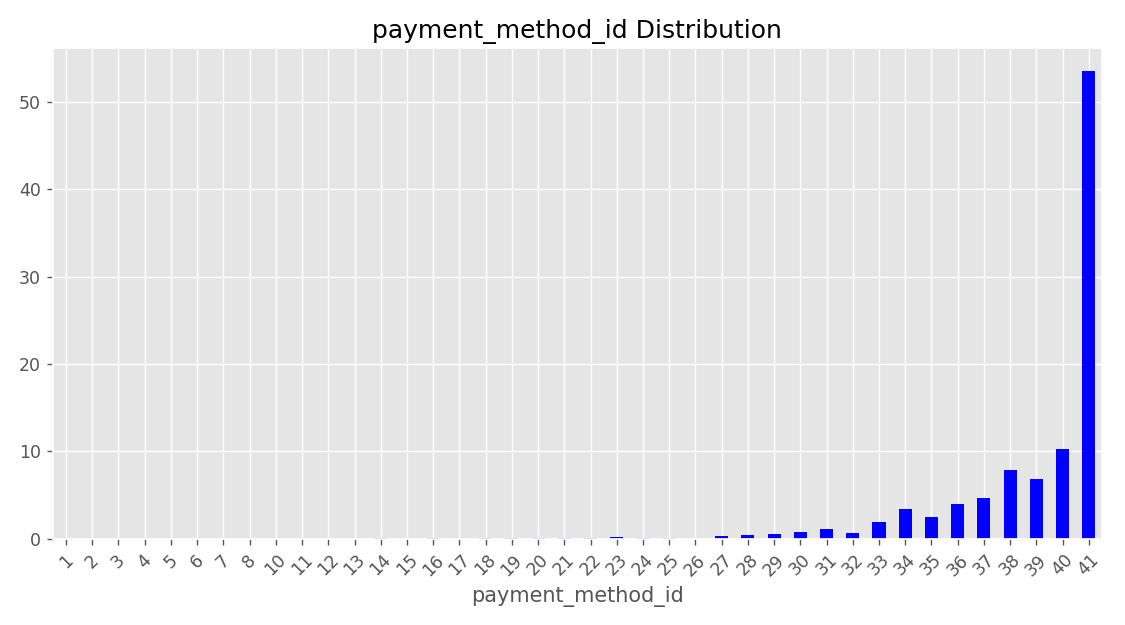

In [7]:
plot_bar(df_transac, ['payment_method_id'])

### Payment Plan in days
There is a lot more variety in subscriptions than I expected
from [KKBOX website](https://help.kkbox.com/hk/zh-tw/billing/pay-types/260), here are the options:
1. Options are monthly plan (30/31 days) with automatic renewal (is_auto_renew true) 
2. Single purchase, no automatic renewal but more expensive:
    3. 30 days
    4. 90 days (plus 7 days bonus?)
    5. 180 days (plus 21 days bonus?)
    6. 365 days (plus 50 days bonus?)
There are discount programs too (getting a credit card with their partners and so on)

0 days doesn't make sense. Because it is low percentage, we can discard it.

We may want to keep only plans shorter than 30/31 days as predicitons are made on a monthly basis.
Indeed, longer subscription means customer will not churn next month

<IPython.core.display.Javascript object>


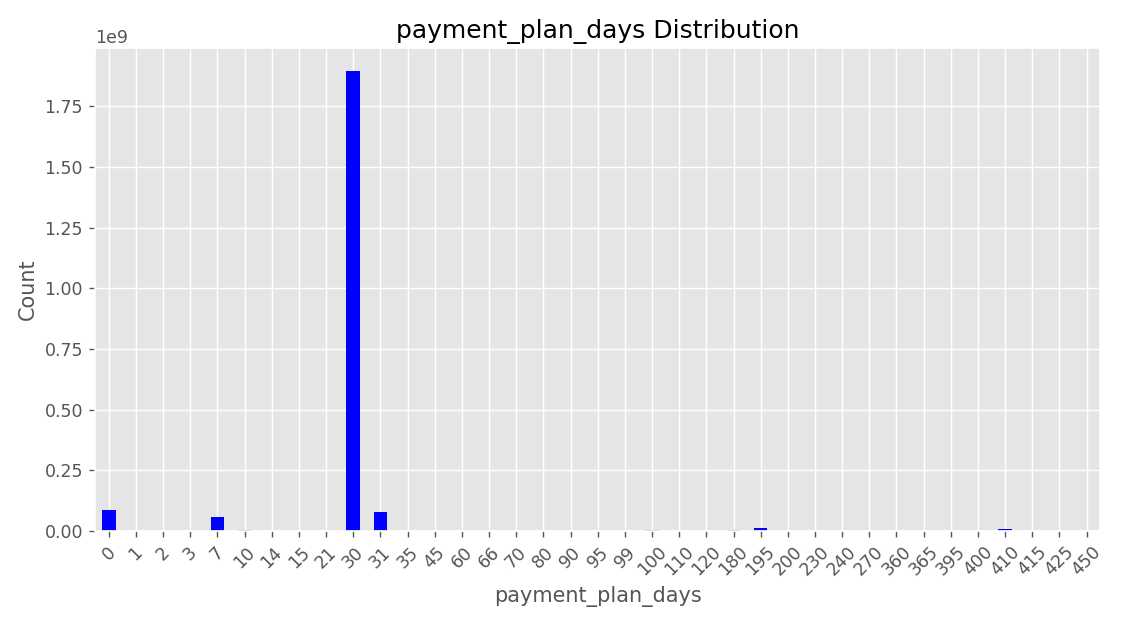

In [8]:
plot_bar(df_transac, ['payment_plan_days'], is_Norm=False)

### A closer look at 0 day plans

Records of 0 day plans also have a list price of 0. All other columns appears to contain legitimate information.

Therefore, payment plan days can be inferred by looking at the time difference between expiration date and transaction date. However, when cancellation is active, it will not work as expiration date is not meaningful. In this latter case, we could look at previous transaction from each respective user if needed.

Note that those transactions occur in 2015 except for 3 in 2016 and 1 in 2017.

In [9]:
# select rows where payment plan days are zero
df_zero_day = df_transac[df_transac.payment_plan_days == 0]

In [10]:
# number of missing value is small
print( '{:.2f}% of total transactions'.format(df_zero_day.shape[0]/df_transac.shape[0] * 100))

4.04% of total transactions


In [11]:
# show that list prices are also zero
df_zero_day.plan_list_price.sum()

0

#### Replacing 0 payment plan days with no active cancellation

Here we assume that expiration and membership dates are valid and number of days ellapsed between those two dates correspond to the plan duration. We should check if this is true for non-zero payment plan days.

In [12]:
df_temp = df_transac[(df_transac.payment_plan_days != 0) & (df_transac.is_cancel == False)].copy()

In [13]:
# compute payment plan days from transaction date and expiration date
df_temp['delta_days'] = (df_temp['membership_expire_date'] - \
                         df_temp['transaction_date']).astype('timedelta64[D]').astype('int64')

In [14]:
df_temp_match = df_temp.loc[df_temp.delta_days == df_temp.payment_plan_days]
print('Percent of Payment Plan Days matching delta plan days = {:.1f} %'.format(\
                                    df_temp_match.shape[0]/df_temp.shape[0]*100))

Percent of Payment Plan Days matching delta plan days = 33.8 %


Using transaction date and expiration date works only for 33.8% of known transactions!

When did it work?

Most likely hapenning when automatic renewal is enabled and transaction date is at the end of the month. Not a reliable method!!!

In [15]:
df_temp_match.head(10)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,delta_days
22,pArK2x3bNZW0sAYaFg0h5c3xkx+2RhLa0RXG88jpt6I=,37,30,149,149,True,2015-10-01,2015-10-31,False,30
62,svvuo4JCElN6TLQZUrMPLuZMpRwcaePM02X3ybNN1dg=,38,30,149,149,False,2015-11-30,2015-12-30,False,30
63,uxUOp7bS37/tqyaiJZnGVAg68YyA7AXEgJ5WDTb6jYE=,37,30,149,149,True,2015-12-01,2015-12-31,False,30
66,aUB5tfRl4tO/EefPzjhKOmAuCVqsmHWYDVgBPpC1/ps=,38,10,0,0,False,2015-12-01,2015-12-11,False,10
67,vIpqkb/ck3zAOqMgqirkrM1rI49dNLPREdznv2X6eTQ=,38,30,149,149,False,2015-12-01,2015-12-31,False,30
83,7Zt2v/N4arQE4GzKCIlXyfiusgo1lAYV3nIIilwMocI=,37,31,149,149,True,2015-02-28,2015-03-31,False,31
99,dtcT8rObhKbpwlvELWNct3wxDNBZ6ffDoJDurNIeslI=,39,31,149,149,True,2015-02-28,2015-03-31,False,31
132,rSdCksIr/MGJ5DXs7R5OyXU13W8u80sijZiFqg6NnLY=,39,31,149,149,True,2015-01-31,2015-03-03,False,31
138,BC5go6E0tWUtp56nWHOE7G4Ma61EIPbzH/KHMlHsuTY=,41,30,149,149,True,2015-03-31,2015-04-30,False,30
139,ouBBjU7/uR2oq7pzBkNXqJBUPRtG7AX5hwWNu2cEO9o=,41,30,149,149,True,2015-03-31,2015-04-30,False,30


### Better approach to substitute 0-day payment plan
Looking at the time ellapsed between two consecutives expiration date is a better way to determine payment plan days. Current transaction date must be anterior to previous expiration date.

We still need to handle active cancellation differently though.

Instead of looping through each group, we can apply our calculation on the whole dataframe at once if we know the index of each customer first transaction. Indeed, we don't want to propagate expiration date from one customer to another.

In [16]:
# sort dataframe by msno, transaction date then expiration date
df_transac.sort_values(['msno', 'transaction_date', 'membership_expire_date'], inplace=True)

In [17]:
# group by users, no need to sort as it is pre-sorted
df_group = df_transac.groupby('msno', sort=False)

In [18]:
# keep track of each user's first transaction
# first_trans2 = []
first_trans = []
import time
start_time = time.time()

# aggregation function first set msno as indexes (original indexes are lost)
for user_name, user_df in df_group:
    # get transactions from user
#     first_trans2.append(user_df.sort_values(['transaction_date', 'membership_expire_date']).index[0])
    first_trans.append(user_df.index[0])
    
print("--- %s seconds ellapsed in for loop---" % (time.time() - start_time))

--- 388.57235288619995 seconds ellapsed in for loop---


In [19]:
# new column showing preceding expiration date for each record
# expect for the first record obviously
# Note: must use .values otherwise it will attempt to align data
df_transac.loc[df_transac.index[1:],'prior_expiration'] =\
                            df_transac.loc[df_transac.index[:-1],'membership_expire_date'].values

In [20]:
# set each user's first transaction to pd.Timedelta('nan') (aka NaT) for prior_expiration.
# It was set to last transaction of preceding user from last operation.
df_transac.loc[first_trans, 'prior_expiration'] = pd.Timedelta('nan')

Blank

In [21]:
# compute delta days when transaction date is anterior to prior expiration date and no active cancellation
crit_mem = (df_transac.transaction_date <= df_transac.prior_expiration) & (df_transac.is_cancel == False)

# estimate payment plan days
df_transac.loc[crit_mem,'delta_days'] = (df_transac.loc[crit_mem, 'membership_expire_date'] - \
                                         df_transac.loc[crit_mem, 'prior_expiration']
                                        ).astype('timedelta64[D]')

In [22]:
# no overlap and no active cancellation
# crit_ept = ~(df_transac.transaction_date <= df_transac.prior_expiration) & (df_transac.is_cancel == False)

# user didn't keep up its membership in a timely manner and no active cancellation
# adding is_auto_renew to false so that first transactions will be processed even if prior exp. is NaT
crit_ept = (~(df_transac.transaction_date <= df_transac.prior_expiration) | (df_transac.is_auto_renew == False)) \
            & (df_transac.is_cancel == False)

# take the expiration/transaction dates difference for non auto renew records
# crit_ept = (df_transac.is_auto_renew == False) & (df_transac.is_cancel == False)

# when there is no overlap with prior transaction, use expiration-transaction date difference
# NOTE: This will not affect user's first transaction as prior expiration is always NaT (check above criterion)
df_transac.loc[crit_ept, 'delta_days'] = (df_transac.loc[crit_ept, 'membership_expire_date'] - \
                                         df_transac.loc[crit_ept, 'transaction_date']
                                        ).astype('timedelta64[D]')

In [25]:
# Use fillna() with forward fill
# When a user cancels, he/she signed up at the first place
df_transac.delta_days.fillna(method='ffill', inplace=True)

# reset each user's first transaction to nan unless auto renew is false
# df_transac.loc[first_trans, 'delta_days'] = np.nan
crit_reset = (df_transac.index.isin(first_trans)) & ((df_transac.is_auto_renew == True) | (df_transac.is_cancel == True))
df_transac.loc[crit_reset, 'delta_days'] = np.nan


In [156]:
# set to 30-days when delta days is between 28 and 33 (number of days in month varies)
crit_30 = (df_transac.delta_days >= 28) & (df_transac.delta_days <= 33)
df_transac.loc[crit_30, 'delta_days'] = 30
df_transac.loc[crit_30, 'payment_plan_days'] = 30

### Expiration date inconsistency
When delta_days is negative, it means membership expiration date is not chronological. It indicates poor data collection and there is no consistent way to fix it unless we know how data were recorded. We have no choice but to drop all transactions from users with no consitency in expiration date. (There is only 4459 records, and often multiple per user)

In [27]:
# remove users with inconsistency in expiration date
users2remove = set(df_transac.loc[(df_transac.delta_days <= 0), 'msno'].values)
df_transac = df_transac.loc[ ~df_transac.msno.isin(users2remove) ,:]

### Unique transactions
When users have a unique transaction and payment plan days is missing (zero), it is tricky to find a replacement. We know transaction/expiration dates are not reliable and plan list price is zero.

We could try to rely on actual paid price. However, non-missing payment plan days shows that actual amount paid occasionally varies for the same payment plan days. Even if we select the most common actual amount, it corresponds to multiple payment plan days.
It will most likely add more noise than signal trying to fill missing values based on the most common of most common value.

In [28]:
# number of transactions per user
s_trans_num = df_group.size()

# list of user's having just one transaction
users_unq_trans = s_trans_num[s_trans_num == 1].index

In [29]:
# remove users with single transaction and missing payment plan days
crit_single = (df_transac.msno.isin(users_unq_trans)) & (df_transac.payment_plan_days == 0)
df_transac = df_transac.loc[ ~crit_single ,:]

### Payment plan days missing value as first transaction
At this point delta days has missing value only for the first transaction of each user.
We can backpropagate payment plan days as long as auto renew is true. The second transaction must be auto renew too or it is an active cancellation with the right payment plan days either way.

In [39]:
# propagate delta days backward, intended for auto renew true and no active cancellation cases
df_transac.delta_days.fillna(method='bfill', inplace=True)

When both auto renew and cancel are true then we only have actual amount as a hint. We already saw it wasn't reliable (see unique transactions). Thus we will disregard those (only 151 transactions).

In [43]:
# reset first transactions to nan for active cancellation (in that case auto renew is also true)
crit_reset = (df_transac.index.isin(first_trans)) & (df_transac.is_cancel == True)
# df_transac.loc[crit_reset, 'delta_days'] = np.nan
df_transac = df_transac.loc[crit_reset, :]

In [66]:
crit_1 = (df_transac.payment_plan_days == 0) & ~(df_transac.delta_days.notnull()) 
crit_2 = (df_transac.payment_plan_days == 0)

In [67]:
df_zero_day = df_transac[crit_1]

In [68]:
df_zero_day.shape

(151, 11)

In [69]:
df_zero_day.head(10)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,prior_expiration,delta_days
11459702,+3El1qcKPba+4HcRjttHJZXxxyt6uVExEjg4oNXv0hM=,41,0,0,149,True,2015-05-09,2015-05-09,True,NaT,NaN
3593149,+Ii2FTuPXUiPTnMeO1Ny5q1YEBrtl1WkDDhTFacnnh8=,33,0,0,149,True,2015-04-27,2015-04-26,True,NaT,NaN
14096474,05GZtJBA9oeniSWw0aoRu3iepc07ZOdQfsw19URkfU0=,41,0,0,149,True,2015-04-30,2015-04-29,True,NaT,NaN
6512511,0GQD1+hEuCGB/RBzjgW8d+5C9lBsfNQqOZI2rd7OfSE=,33,0,0,149,True,2015-05-01,2015-03-31,True,NaT,NaN
4032570,1+HiftkTOYVTMvMUihSfTq4F/V4cQ+MSxgwDoZJyJ5s=,19,0,0,149,True,2015-04-26,2015-04-27,True,NaT,NaN
7672011,14fp60sLHOmFbzB+Y1AHSnP4asiQNisjvuIvmMKsTyo=,41,0,0,149,True,2015-05-07,2015-05-06,True,NaT,NaN
20872328,1Afyy+IxRW/CqY1prbU8nMrW0Gag15g/UXkCTfFY478=,31,0,0,149,True,2015-04-30,2015-03-31,True,NaT,NaN
8135988,1Hiu69vOcoFME/k6XkaSb8aouLSw86qtzoM0hSOWHoM=,34,0,0,149,True,2015-05-01,2015-04-01,True,NaT,NaN
18445754,1IRP4r4Bf5+31aeHha3skdHUN/zx/S8sU7dB1gsX7F0=,31,0,0,149,True,2015-04-27,2015-04-26,True,NaT,NaN
14855762,1hos9XabAlZboEEGrra+/rHxXyDlk3yfxVA5opXLQsE=,33,0,0,149,True,2015-04-25,2015-04-26,True,NaT,NaN


In [147]:
# df_group.get_group('hPTUSf0yN5su3crCqMFqPsS1bh4G96NkLn5x8u1TgfM=')   # no missing values BUT inconsistent
# df_group.get_group('1hos9XabAlZboEEGrra+/rHxXyDlk3yfxVA5opXLQsE=')

In [164]:
# # select unique transaction with no missing payment plan days and no active cancellation
# crit_fill_plan = (df_transac.msno.isin(users_unq_trans)) &
#                      (df_transac.payment_plan_days != 0) &
#                      (df_transac.is_cancel == False)

# select first transactions with no missing payment plan days and no active cancellation
# crit_fill_plan = (df_transac.index.isin(first_trans)) & (df_transac.payment_plan_days != 0) & (df_transac.is_cancel == False)
crit_fill_plan = (df_transac.payment_plan_days != 0) & (df_transac.is_cancel == False)

In [165]:
# group by payment plan days
df_plan_grouped = df_transac[ crit_fill_plan ].groupby('payment_plan_days')

In [166]:
# count number of actual amount for each payment plan days
s_mcommon = df_plan_grouped.actual_amount_paid.value_counts()

In [167]:
# count total number of actual amount for each payment plan days and broadcast values to actual amount groups
s_1, s_2 = s_mcommon.align(s_mcommon.sum(level = 0), axis = 0, level = 0)

In [168]:
# concatenate in a single multi-index dataframe
df_mcommon =  pd.concat([s_1, s_2], axis = 1)

# rename columns
df_mcommon.columns = ['amount_count', 'total_amount_count']

In [169]:
df_mcommon['amount_proba'] = df_mcommon.amount_count / df_mcommon.total_amount_count * 100

In [175]:
df_mcommon

amount_count  total_amount_count  \
payment_plan_days actual_amount_paid                                     
1                 0                           3637                3637   
2                 10                            67                  67   
3                 15                            47                  55   
                  0                              8                  55   
7                 0                         532470              539526   
                  35                          7056              539526   
10                0                          30663               31670   
                  50                          1007               31670   
14                0                           5426                5657   
                  70                           231                5657   
15                0                             21                  21   
21                0                            503                 835   
                  105                          332                 835   
30                149                     11654564            19233064   
                  99                       4709406            19233064   
                  129                      1084151            19233064   
                  180                       650915            19233064   
                  150                       391503            19233064   
                  119                       330116            19233064   
                  0                         326259            19233064   
                  100                        75673            19233064   
                  134                         4594            19233064   
                  120                         4112            19233064   
                  124                          598            19233064   
                  131                          557            19233064   
                  35                           218            19233064   
                  143                          141            19233064   
                  127                           99            19233064   
                  1                             72            19233064   
                  210                           22            19233064   
...                                            ...                 ...   
180               760                            4               51739   
                  600                            3               51739   
195               894                       108481              109610   
                  0                           1127              109610   
                  849                            1              109610   
                  890                            1              109610   
200               930                         5062                5816   
                  1000                         748                5816   
                  0                              4                5816   
                  894                            2                5816   
230               1150                         102                 102   
240               0                            553                 553   
270               894                          186                 186   
360               1200                        5461                5461   
365               1788                         222                 310   
                  0                             73                 310   
                  1520                          13                 310   
                  1825                           2                 310   
395               1599                        9700               10761   
                  0                           1061               10761   
400               1599                        1729                1846   
                  2000                    

In [177]:
df_mcommon_solid = df_mcommon[df_mcommon.amount_proba >= 95].reset_index(level = 1)
df_mcommon_solid

,actual_amount_paid,amount_count,total_amount_count,amount_proba
payment_plan_days,,,,
1,0,3637,3637,100.000000
2,10,67,67,100.000000
7,0,532470,539526,98.692185
10,0,30663,31670,96.820335
14,0,5426,5657,95.916564
15,0,21,21,100.000000
35,149,818,818,100.000000
45,180,1080,1080,100.000000
66,298,174,174,100.000000


In [181]:
# use z-score instead of nlargest
s_plan_rpl = df_mcommon_solid.groupby('actual_amount_paid').total_amount_count.nlargest(1)
s_plan_rpl = s_plan_rpl.reset_index(level = 1)
s_plan_rpl.drop('total_amount_count', axis = 1, inplace = True)

In [184]:
# don't replace when actu
s_plan_rpl = s_plan_rpl.iloc[1:]

,payment_plan_days
actual_amount_paid,
0,7
10,2
45,95
149,35
180,45
298,66
350,70
400,80
447,99


### Auto-renew and active cancellation
People who have auto renewal active also don't cancel actively. It is consitent with the fact that most customers don't churn.

In [ ]:
plot_bar(df_transac, ['is_auto_renew' , 'is_cancel'])

### Plan list price
Plan prices are rather discrete therefore there could be categorized for analysis.<br>
Notice some transactions were free probably due to trial period or initial offering. Although, I would expect the actual price paid to be zero. <br>
PS: Plan prices greater than 180 NTD only represents 2% of all transactions.

In [ ]:
df_transac.plan_list_price.quantile(q = 0.98)

In [ ]:
_ , axListPrice = plt.subplots()
_ = df_transac.plan_list_price.plot(kind = 'hist', \
                                bins = 250, range = (0,250), density = True,\
                                ax = axListPrice)
_ = axListPrice.set_xlabel('Plan list Price')

### Subscription cost per subscription length
How do subscription length scale with list price ? <br>
First, let's group plan duration by the following intervals in days:
| 0 - 7 | 8 - 29 | 30 - 89 | 90 - 179 | 180 - 364  | 365 - 450 |


In [ ]:
# create custom intervals (bin edges will be left inclusive) in increasing order
days_plan = [0, 8, 30, 90, 180, 365, 451 ]

# compile labels
days_plan_upperbounds = [d-1 for d in days_plan[1:-1] ]
days_plan_upperbounds.append(days_plan[-1])
days_plan_labels = [ "{} - {}".format(l,u) for l,u in zip(days_plan[:-1], days_plan_upperbounds) ]

print('Bin edges = {}'.format(days_plan))
print('Associated labels = {}'.format(days_plan_labels))

In [ ]:
# create new column with plan duration category
df_transac['plan_duration'] = pd.cut(df_transac.payment_plan_days, days_plan, right=False, labels=days_plan_labels)

Create bar plot for each auto renew state (True or False) and observe the list price going up with subscription length globally.<br> Free subscription are available across all subscription length.

In [ ]:
# prepare axis
_ , axCostDays = plt.subplots(2, 1, \
                              figsize=(8, 8), \
                              gridspec_kw=dict(height_ratios=[1, 3]))

# pivot on relevant columns, values can be anything as we are just counting here
df_plan = df_transac.pivot_table(index = 'plan_duration', columns = 'is_auto_renew',\
                                 values = 'plan_list_price', aggfunc = 'count', fill_value = 0)

# normalize each column by counts
df_plan = df_plan.divide(df_plan.sum()) * 100

# make a bar plot for each auto renew state
df_plan.plot(kind = 'bar', ax = axCostDays[0])

# change tick orientation and add labels
axCostDays[0].tick_params(axis = 'x', rotation = 0)
axCostDays[0].set_ylabel('Percent (%)')
axCostDays[0].set_xlabel('plan_duration')


# use seaborn to add plan list price as another dimension
sns.stripplot(x="plan_duration", y="plan_list_price", hue = 'is_auto_renew',\
              dodge = True, jitter = True, alpha = 0.25,\
              data=df_transac, ax = axCostDays[1])
# sns.swarmplot(x="plan_duration", y="plan_list_price", hue = 'is_auto_renew',\
#               dodge = True, alpha = 0.25,\
#               data=df_transac, ax = axCostDays[1])

plt.tight_layout()

The Empirical cumulative distribution function (ECDF) can give us another view when there are too many points to plot.

In [ ]:
_ , axEcdf = plt.subplots(1, 2, figsize=(9, 6), gridspec_kw=dict(width_ratios=[3, 1]))

for i in range(2):
    # sort your data and plot it versus its percentage increment
    for pl in days_plan_labels:
        filt_pl = (df_transac.is_auto_renew == i ) & (df_transac.plan_duration == pl)
        pl_x = df_transac.loc[filt_pl, 'plan_list_price'].sort_values().values
        pl_y = np.arange(1, len(pl_x)+1) / len(pl_x)
        axEcdf[i].plot(pl_x, pl_y, '.')
        axEcdf[i].set_xlabel('Plan List Price (auto_renew = ' + str(bool(i)) + ')'  )
        axEcdf[i].set_ylabel('ECDF')
    axEcdf[i].legend(days_plan_labels)

### List price vs paid price
If we compile the percent discount between actual amount and list price (assuming actual amount is always lower or equal to list price), some value will be infinity between we would divide by 0 (when x->0 (1/x)->Inf) <br>
So we should filter out those events that represents ~ 7.5% of all transactions.

In [ ]:
df_discount = df_transac[~(df_transac.plan_list_price == 0)]

In [ ]:
# percent difference between plan price and price actually paid
discount_percent = 1 - (df_discount.actual_amount_paid/df_discount.plan_list_price)

It appears that an overwhelming majority of transcations do not have any discount (more than 95%).<br>
Note: bin width is 0.1 thus normalization is multiplied by 10 (divided by 0.1). It means 100% corresponds to 10 on the y scale.

In [ ]:
# plot histogram of discounts
_ , axDiscount = plt.subplots()

# plot histogram, bin by 10% intervals
_ = discount_percent.plot(kind = 'hist', range = (-1,1), bins = 20, ax = axDiscount, density = True)

_ = axDiscount.set_xlabel('Discount fraction')

### Transaction and expiration dates
Transactions start in January 2015 up to February 2017. <br>
Membership expiration date takes into account the result of this transaction. For instance, a user who signs up for 2 months will have a membership expiration date 2 months after transaction date. In constrast, a user who actively cancels his plan is recorded as a transaction where expiration date is typically the day after transaction date.

In [ ]:
df_transac.transaction_date.describe()

In [ ]:
# compute difference in time between expiration date and transaction date
deltaTransacDate = df_transac.membership_expire_date - df_transac.transaction_date

# convert timedelta to days (it will produce integer)
deltaTransacDate = deltaTransacDate.astype('timedelta64[D]')

# convert timedelta object to days (2 solutions below keep decimals, astype does a floor)
# deltaTransacDate = deltaTransacDate/pd.Timedelta('1 day')
# deltaTransacDate = deltaTransacDate/np.timedelta64(1, 'D')

Without surprise, most people renew their membership for 30 or 31 days (Most popular plan). There are other smaller peaks at 0 day, 60 days and 90 days. Users who actively cancels is represented by the 0 day peak.

In [ ]:
# histogram days, matplotlib hist composes bin with right edge excluded EXCEPT for the last bin
_ , axTransacDate = plt.subplots()

_ = deltaTransacDate.plot(kind = 'hist', range= (-30, 90), bins = 120, density = True, ax = axTransacDate)

_ = axTransacDate.set_xlabel('Delta in days (expiration date - transaction date)')

# NOTE: there are some unrealistic out of range values like -17599 days